# 1. 加载需要的库

In [336]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# display Chinese characters
rcParams['font.family'] = "FZXiHei I-Z08S"
rcParams['font.size'] = '14'

# 2. 加载数据

把测试数据和训练数据进行合并，用于统一进行对数据进行清洗和转换
训练数据的 PassengerId 到891，剩余的都是测试数据

In [337]:
df_train = pd.read_csv('./data/train.csv',index_col=['PassengerId'])
df_test = pd.read_csv('./data/test.csv', index_col=['PassengerId'])
target = df_train['Survived']
df_full = pd.concat([df_train, df_test])
#df_full.drop(labels=['Survived'], axis=1, inplace=True)

# 3. 数据整体情况
# 3.1 数据概览

In [338]:
print("数据维度信息:", df_full.shape)
num_of_numerical_cols = df_full._get_numeric_data().columns.shape[0]
print("数字类型特征数量",num_of_numerical_cols,)
print("条目类型特征数量", df_full.shape[1] - num_of_numerical_cols)
print("数据信息摘要:")
print(df_full.describe())
print("数据前10条显示:")
print(df_full.head())

数据维度信息: (1309, 11)
数字类型特征数量 6
条目类型特征数量 5
数据信息摘要:
               Age         Fare        Parch       Pclass        SibSp  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027     2.294882     0.498854   
std      14.413493    51.758668     0.865560     0.837836     1.041658   
min       0.170000     0.000000     0.000000     1.000000     0.000000   
25%      21.000000     7.895800     0.000000     2.000000     0.000000   
50%      28.000000    14.454200     0.000000     3.000000     0.000000   
75%      39.000000    31.275000     0.000000     3.000000     1.000000   
max      80.000000   512.329200     9.000000     3.000000     8.000000   

         Survived  
count  891.000000  
mean     0.383838  
std      0.486592  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  
数据前10条显示:
              Age Cabin Embarked     Fare  \
PassengerId                                 
1   

#  3.1 数据缺失情况

In [339]:
def get_missing():
    data_df_na = df_full.isnull().mean(axis=0)
    data_df_na = data_df_na.drop(data_df_na[data_df_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'missing_rate': data_df_na})
    print('missing_data.shape = ', missing_data.shape)
    return missing_data
missing_data = get_missing()
missing_data

missing_data.shape =  (5, 1)


,missing_rate
Cabin,0.774637
Survived,0.319328
Age,0.200917
Embarked,0.001528
Fare,0.000764


Text(0.5,1,'特征数据丢失率一览图')

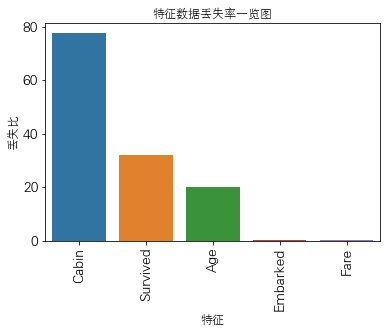

In [340]:
sns.barplot(x = missing_data.index, y = 100 *missing_data.missing_rate )
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = (18,4)
plt.xlabel('特征', fontsize=12)
plt.ylabel('丢失比', fontsize=12)
plt.title('特征数据丢失率一览图', fontsize=12)

# 3.2 缺失数据特征与目标值的关联关系
用以了解缺失的数据特征是否与目标值关系较大，如果较大，则要想办法补充，否则可以简单丢弃

对于 Embarked和 Fare这两个特征丢失较少，直接采取平均数补充

In [341]:
df_full['Embarked'] = df_full['Embarked'].fillna(df_full['Embarked'].mode()[0])
df_full['Fare']  = df_full['Fare'].fillna(df_full['Fare'].mean())

### 3.2.1 舱位数据分析
从舱位数据来看，应该是分了等级或者是分了层次，因为，首先考虑把舱位信息的首字母提取，假定为等级，看看等级与获救之间的关系

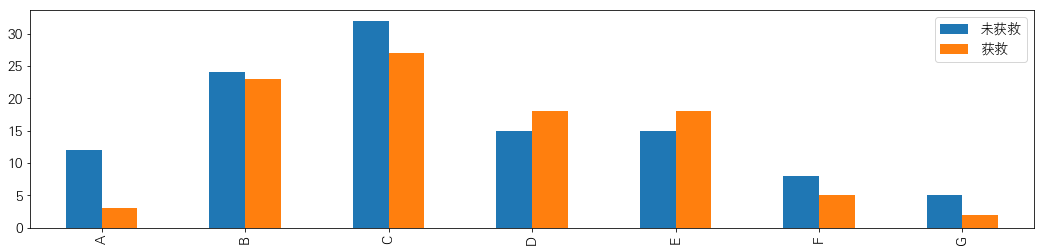

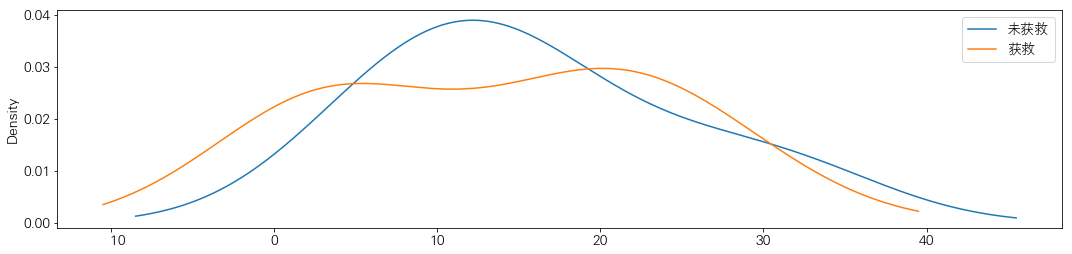

In [342]:
cabins = {}
for cab, surv in df_train[['Cabin','Survived']].values:
    if isinstance(cab, float):
        continue
        n, y = cabins.get('None',(0,0))
        if surv == 1:
            y +=1
        else:
            n +=1
        cabins['None'] = (y,n)
    else:
        cabs = set([x[0] for x in cab.split(' ')])
        for c in cabs:
            n, y = cabins.get(c,(0,0))
            if surv == 1:y +=1
            else: n +=1
            cabins[c] = (y,n)

df  = pd.DataFrame(cabins, index=['dead','survived'])
del df['T']
#plt.plot(df.iloc[0,:])
d = pd.DataFrame({'获救': df.loc['survived'], '未获救':df.loc['dead']})
d.plot(kind='bar')
d.plot(kind='kde')

### 3.2.2 客舱等级与获救的关系

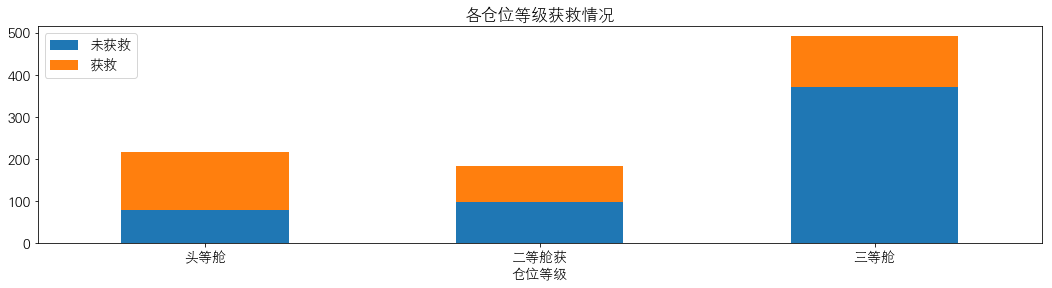

In [343]:
surv = df_train.Pclass[df_train.Survived == 1].value_counts()
nosurv = df_train.Pclass[df_train.Survived == 0].value_counts()
d = pd.DataFrame({'获救': surv, '未获救': nosurv})
#d = pd.DataFrame({'头等舱获救情况':p1, '二等舱获救情况':p2,'三等舱获救情况':p3})
d.plot(kind='bar', stacked=True)
plt.title('各仓位等级获救情况')
plt.xlabel('仓位等级')
plt.xticks(np.arange(3), ['头等舱', '二等舱获','三等舱'],rotation=0)
plt.rcParams['figure.figsize'] = (6,4)

# 3.2.3 年龄与获救关系
年龄应该和获救关系很大了，毕竟当时人乘坐救生艇的原则妇女和小孩优先
先看年龄分布情况

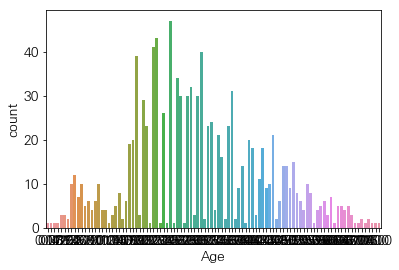

In [344]:
sns.countplot(df_full.Age)

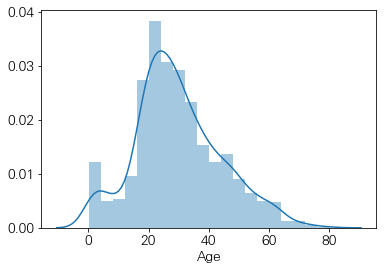

In [345]:
sns.distplot(df_full.Age.dropna(), bins=20)

再看年龄和获救关系

0.42
80.0


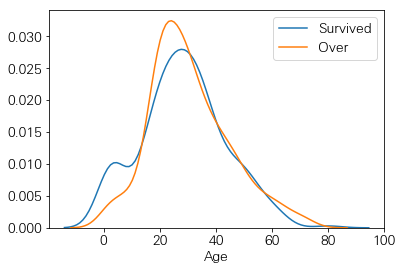

In [346]:
print(df_train.Age.min())
print(df_train.Age.max())
sns.distplot(df_train.Age[df_train['Survived'] == 1].dropna(), hist=None, kde=True, label='Survived')
sns.distplot(df_train.Age[df_train['Survived'] == 0].dropna(), hist=None, kde=True, label='Over')

看一眼缺失年龄的数据概览

In [347]:
df_full[df_full.Age.isnull()].head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0,330877
18,NaN,NaN,S,13.0000,"Williams, Mr. Charles Eugene",0,2,male,0,1.0,244373
20,NaN,NaN,C,7.2250,"Masselmani, Mrs. Fatima",0,3,female,0,1.0,2649
27,NaN,NaN,C,7.2250,"Emir, Mr. Farred Chehab",0,3,male,0,0.0,2631
29,NaN,NaN,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,3,female,0,1.0,330959
30,NaN,NaN,S,7.8958,"Todoroff, Mr. Lalio",0,3,male,0,0.0,349216
32,NaN,B78,C,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,1,female,1,1.0,PC 17569
33,NaN,NaN,Q,7.7500,"Glynn, Miss. Mary Agatha",0,3,female,0,1.0,335677
37,NaN,NaN,C,7.2292,"Mamee, Mr. Hanna",0,3,male,0,1.0,2677


## 3.3 数据整理与缺失填充

### 3.3.1 姓名特征处理

目前我们很难直接看出姓名与获救之间存在怎样的关联习惯，从姓名一栏来看，可能有用的是一个是包含职业或者教育程度，至少我看了有 Doctor 的简称，但是不太多。但是看姓名，基本上都有 Miss,Mr, Mrs 这样的称呼。
因此，我们暂时提取这些关键信息作为需要特征，我们称之为 Title

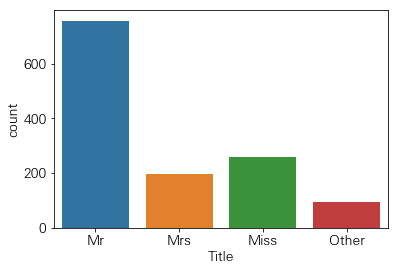

In [348]:
df_full['Title'] = df_full['Name']
df_full['Title'][df_full['Title'].str.contains('Miss.', regex=False)] = 'Miss'
df_full['Title'][df_full['Title'].str.contains('Mrs.', regex=False)] = 'Mrs'
df_full['Title'][df_full['Title'].str.contains('Mr.', regex=False)] = 'Mr'
df_full['Title'][df_full['Title'].str.contains(r'[^Mr|Miss|Mrs]')] = 'Other'
sns.countplot(df_full['Title'])

### 3.3.2 年龄特征处理
因为年龄这个特征太重要了，它和是否获救有非常强的关联关系，因此需要慎重对待缺失的数据。

尝试过采集随机森林方法来填充缺失的年龄，但是从结果来看，效果似乎不太理想，这里想采取和姓名相关联的方法，及找到那些称谓相同的（3.3.1处理）人的平均年龄进行填充

In [349]:
d = df_full.groupby(['Title'])['Age'].mean()
for cate, value in d.items():
    df_full['Age'][(df_full.Title == cate) & df_full.Age.isnull()] = '{:.2f}'.format(value)
    
print(df_full.Age.isnull().any())

False


因为获救时，是考虑到妇女和小孩优先，妇女这个特征比较难以鉴别，但是小孩我们可以通过年龄甄别出来。

我们先把年龄进行分段，看看那个年龄阶段的获救几率最大。

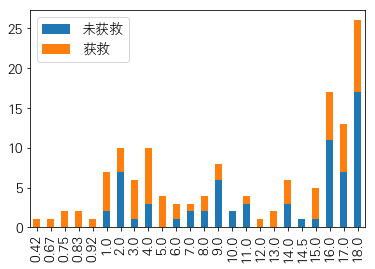

In [361]:
age_box = [0, 6, 12, 18, 25, 40, 50, 80]
children = df_full.loc[df_full.Age.astype('float') <=18,['Survived','Age']]
d = pd.DataFrame({'获救': children.Age[children.Survived == 1].value_counts(), 
                  '未获救': children.Age[children.Survived == 0].value_counts()})
d.plot(kind='bar', stacked=True)

把儿童年龄设定在13岁及以下

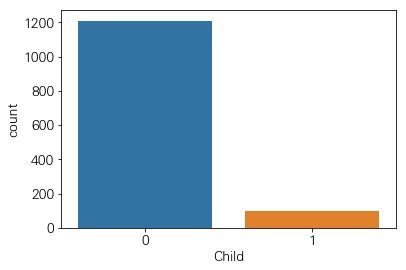

In [367]:
df_full['Child'] = 0
df_full['Child'][df_full.Age.astype('float') <=13] = 1
sns.countplot(df_full['Child'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def fill_other_missing_age():
    cols = ['Age', 'Fare',  'Parch', 'Pclass', 'SibSp']
    data = df_full[cols]
    X = data[data.Age.notnull()].as_matrix()
    test = data[data.Age.isnull()].as_matrix()
    y = X[:, 0]
    X = X[:, 1:]


    age_model = RandomForestRegressor(n_estimators=30,  verbose=1, n_jobs=-1, random_state=0)
    age_model.fit(X, y)
    pred_age = age_model.predict(test[:, 1:])
    df_full.loc[df_full.Age.isnull(), 'Age'] = pred_age

if False:
    fill_other_missing_age()

### 3.3.3 家族特征处理
数据提供了父母孩子，堂表兄妹的数量数据，考虑增加一个字段，就是当前家庭成员数量，看看是不是“家族”越大，获救的几率越大

In [ ]:
df_full['Family'] = df_full['Parch'] + df_full['SibSp']

### 3.3.4  仓位(Cabin) 处理
把仓位的首字母提取出来，如果存在多个的，取多数字母那个，如果平局的话，则取第一个

没有的，则填写字母 N

In [375]:
from collections import Counter
def get_cabin_caption(x):
    if x == 'nan':
        return 'N'
    cabs = [i[0] for i in x.split(' ')]
    return Counter(cabs).most_common(1)[0][0]
            
df_full['Cabin_Caption'] = df_full['Cabin'].astype('str').apply(lambda x: get_cabin_caption(x))
df_full['Cabin_Caption'].value_counts()

N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_Caption, dtype: int64

### 3.3.4 特征组合
从数据分析来看，仓位等级与性别以及性别和年龄是比较重要的因素，我们可以组合这两者形成两个新的特征

In [371]:
df_full['Sex_Pclass'] = df_full['Sex'].astype('str') + '_' + df_full['Pclass'].astype('str')
df_full['Sex_Age'] = df_full['Sex'].astype('str') + '_' + df_full['Age'].astype('str')
print(df_full['Sex_Pclass'].head())
print(df_full['Sex_Age'].head())

PassengerId
1      male_3
2    female_1
3    female_3
4    female_1
5      male_3
Name: Sex_Pclass, dtype: object
PassengerId
1      male_22.0
2    female_38.0
3    female_26.0
4    female_35.0
5      male_35.0
Name: Sex_Age, dtype: object


### 3.3.5 去掉不需要的特征
这里，我们可以暂时去掉一些经过我们处理，或者特征用不上的字段了

一种可能性是从船票中提取有用的信息，比如看是否从船票里知道所在的仓位，所在的位置等，如果获取不到，那这个特性只能暂时丢弃

[这个网站](http://www.keyflux.com/titanic/facts.htm)提供了一些有意思的信息

In [378]:
df_full.drop(labels=['Name','Cabin','Ticket','Survived'], axis=1, inplace=True)

重新检查数据是否有缺失

In [379]:
missing_data = get_missing()
print(missing_data)

missing_data.shape =  (0, 1)
Empty DataFrame
Columns: [missing_rate]
Index: []


In [383]:
df_full.dtypes

Age              float64
Embarked          object
Fare             float64
Parch              int64
Pclass             int64
Sex               object
SibSp              int64
Title             object
Child              int64
Sex_Pclass        object
Sex_Age           object
Cabin_Caption     object
dtype: object

In [382]:
df_full['Age'] = df_full['Age'].astype('float')

# 4 数据编码
对非数值特征进行编码，可以考虑分别尝试用 one-hot 编码和 labelencoder 编码

In [185]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
for col in ['Title', 'Sex_Pclass', 'Sex_Age', 'Embarked', 'Cabin_Caption']:
    lb.fit(df_full[col])
    df_full[col] = lb.transform(df_full[col]).astype('str')

In [188]:
# from sklearn.preprocessing import RobustScaler
# def normalizer(data):
#     scaler = RobustScaler()
#     scaler.fit(data)
#     return scaler.transform(data)
# num_of_numerical_cols =  df_full._get_numeric_data().columns
# for col in num_of_numerical_cols:
#     df_full[col] = normalizer(df_full[col].reshape(-1,1))
# df_full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp
PassengerId,,,,,,,,,
1,-0.437709,7,2,-0.308146,1,0.0,0.0,1,1.0
2,0.628957,2,0,2.430755,1,0.0,-2.0,0,1.0
3,-0.171043,7,2,-0.279274,0,0.0,0.0,0,0.0
4,0.428957,2,2,1.652999,1,0.0,-2.0,0,1.0
5,0.428957,7,2,-0.273927,1,0.0,0.0,1,0.0


## 4.5 目前的数据情况

In [189]:
print("数据维度信息:", df_full.shape)
num_of_numerical_cols = df_full._get_numeric_data().columns.shape[0]
print("数字类型特征数量",num_of_numerical_cols,)
print("条目类型特征数量", df_full.shape[1] - num_of_numerical_cols)
print("\n数据信息摘要:")
print(df_full.describe())
print("\n数据前10条显示:")
print(df_full.head())
print("\n是否存在空值")
print(df_full.isnull().any())

数据维度信息: (1309, 9)
数字类型特征数量 5
条目类型特征数量 4

数据信息摘要:
               Age         Fare        Parch       Pclass        SibSp
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000
mean      0.085885     0.805899     0.385027    -0.705118     0.498854
std       0.895233     2.213030     0.865560     0.837836     1.041658
min      -1.893043    -0.618250     0.000000    -2.000000     0.000000
25%      -0.437709    -0.280523     0.000000    -1.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.562291     0.719477     0.000000     0.000000     1.000000
max       3.428957    21.295639     9.000000     0.000000     8.000000

数据前10条显示:
                  Age Cabin Embarked      Fare Name  Parch  Pclass Sex  SibSp
PassengerId                                                                  
1           -0.437709     7        2 -0.308146    1    0.0     0.0   1    1.0
2            0.628957     2        0  2.430755    1    0.0    -2.0 

# 5. 建模及预测
## 5.1 创建集成模型

In [152]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

paralles = 1

rfc = RandomForestClassifier(n_estimators=1000, n_jobs=paralles, max_depth=4)
bc = BaggingClassifier(n_estimators=1000, n_jobs=paralles)
etc = ExtraTreesClassifier(n_estimators=1000, n_jobs=paralles)
adboost = AdaBoostClassifier(n_estimators=1000)
lr = LogisticRegression(n_jobs=paralles, C=1.0, penalty='l1', tol=1e-6)
xgboost = XGBClassifier(learning_rate =0.15, n_estimators=300, max_depth=4, gamma=0, subsample=0.8)
gboost = GradientBoostingClassifier(n_estimators=1000, max_depth=4, learning_rate=0.15)

model = StackingCVClassifier(classifiers=[rfc, bc, etc, adboost, lr, xgboost, gboost],
                             meta_classifier=lr, verbose=1, cv=10, use_probas=True)
model

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_frac...       presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)],
           cv=10,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False),
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_features_in_secondary=False, use_probas=True, verbose=1)

## 5.2 数据分隔

In [190]:
from sklearn.model_selection import train_test_split
#train_data = df_full[0:891,:]
#test_data = df_full[891:,:]
train_data = df_full.iloc[0:891].as_matrix()
test_data = df_full.iloc[891:].as_matrix()
target_y = target.as_matrix()
X_train, X_test, y_train ,y_test = train_test_split(train_data, target_y, test_size=0.1, random_state=0)

## 5.3 训练

In [201]:
model.fit(train_data, target_y)

Fitting 7 classifiers...
Fitting classifier1: randomforestclassifier (1/7)
Training and fitting fold 1 of 10...
Training and fitting fold 2 of 10...
Training and fitting fold 3 of 10...
Training and fitting fold 4 of 10...
Training and fitting fold 5 of 10...
Training and fitting fold 6 of 10...
Training and fitting fold 7 of 10...
Training and fitting fold 8 of 10...
Training and fitting fold 9 of 10...
Training and fitting fold 10 of 10...
Fitting classifier2: baggingclassifier (2/7)
Training and fitting fold 1 of 10...
Training and fitting fold 2 of 10...
Training and fitting fold 3 of 10...
Training and fitting fold 4 of 10...
Training and fitting fold 5 of 10...
Training and fitting fold 6 of 10...
Training and fitting fold 7 of 10...
Training and fitting fold 8 of 10...
Training and fitting fold 9 of 10...
Training and fitting fold 10 of 10...
Fitting classifier3: extratreesclassifier (3/7)
Training and fitting fold 1 of 10...
Training and fitting fold 2 of 10...
Training and fit

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_frac...       presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)],
           cv=10,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False),
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_features_in_secondary=False, use_probas=True, verbose=1)

## 5.4 模型校验和性能测试

In [202]:
print("train score:", model.score(train_data,target_y))
#print("valid score:", model.score(X_test, y_test))

train score: 0.9259259259259259


In [204]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import  classification_report
pred_y = model.predict(train_data)
#pred_test = model.predict(X_test)
print(confusion_matrix(target_y, pred_y))
print(classification_report(target_y, pred_y))

[[534  15]
 [ 51 291]]
             precision    recall  f1-score   support

          0       0.91      0.97      0.94       549
          1       0.95      0.85      0.90       342

avg / total       0.93      0.93      0.93       891



## 5.5 预测与数据提交

In [200]:
pred = model.predict(test_data)
submission = pd.DataFrame({'PassengerId': range(892,1310), 'Survived': pred})
print(submission.head())
submission.to_csv('./titanic_prediction.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
